In [2]:
%load_ext autoreload
%autoreload 2

import os, sys, numpy as np
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
%matplotlib widget

In [3]:
from LinearMPC.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [4]:
Ts = 0.05
sim_time = 30  # Increased to see fuel exhaustion
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl.new_controller(rocket, Ts, H)

rocket.mass = 2.0
rocket.fuel_rate = 0.1

# Wrap simulation in try-except to handle fuel exhaustion gracefully
try:
    t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
        mpc, sim_time, H, x0, x_target=x_target, method='nonlinear'
    )
    fuel_exhausted = False
except ValueError as e:
    if "Fuel exhausted" in str(e):
        print(f"\n*** FUEL EXHAUSTED at approximately t = {rocket.fuel_consumption / rocket.fuel_rate:.1f}s ***")
        print("Simulation stopped - rocket can no longer produce thrust!")
        fuel_exhausted = True
        # The simulation data up to this point is lost, so we need to re-run with shorter time
        # Let's estimate when fuel runs out and simulate just before that
        rocket2 = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
        mpc2 = MPCVelControl.new_controller(rocket2, Ts, H)
        rocket2.mass = 2.0
        rocket2.fuel_rate = 0.1
        # Estimate: fuel = mass/2 = 1.0 kg, at ~56% throttle, consumption ~0.1 * 0.05 * 56/100 per step
        # Try a slightly shorter simulation
        t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket2.simulate_control(
            mpc2, 18, H, x0, x_target=x_target, method='nonlinear'
        )
    else:
        raise

print(f"\nSimulation completed. Final time: {t_cl[-1]:.2f}s")
print(f"Final position: x={x_cl[9,-1]:.2f}, y={x_cl[10,-1]:.2f}, z={x_cl[11,-1]:.2f}")
print(f"Final velocity: vx={x_cl[6,-1]:.2f}, vy={x_cl[7,-1]:.2f}, vz={x_cl[8,-1]:.2f}")

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, Ref=ref[:, :-1], T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulating time 0.00: Fuel left: 1.00 kg, 
Simulating time 0.05: Fuel left: 1.00 kg, 
Simulating time 0.10: Fuel left: 0.99 kg, 
Simulating time 0.15: Fuel left: 0.99 kg, 
Simulating time 0.20: 
 State beta violation: -0.195455 < -0.174533, 
 State alpha violation: 0.192867 > 0.174533, Fuel left: 0.99 kg, 
Simulating time 0.25: 
 State beta violation: -0.302596 < -0.174533, 
 State alpha violation: 0.307030 > 0.174533, Fuel left: 0.99 kg, 
Simulating time 0.30: 
 State beta violation: -0.427995 < -0.174533, 
 State alpha violation: 0.457419 > 0.174533, Fuel left: 0.99 kg, 
Simulating time 0.35: 
 State bet

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=359, step=2), IntSlider(value=0…

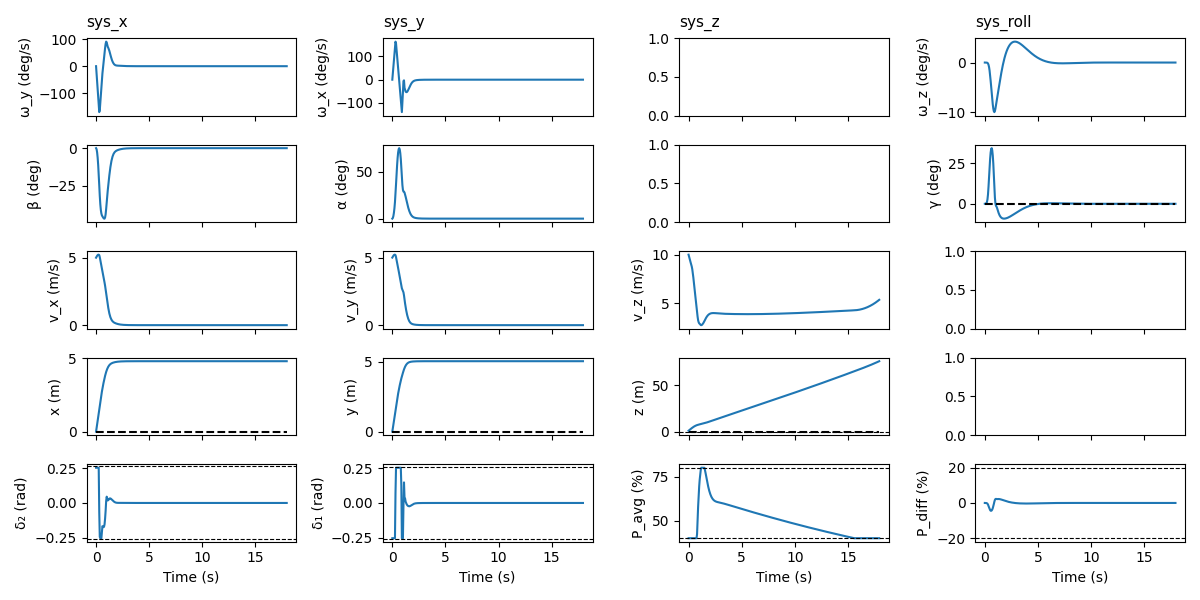


DELIVERABLE 5.2 - Simulation with Changing Mass
Initial mass: 2.0 kg (fuel = 1.0 kg)
Fuel rate: 0.1
Initial position: [0, 0, 1] m
Initial velocity: [5, 5, 10] m/s
Velocity reference: [0, 0, 0] m/s
------------------------------------------------------------
*** Fuel was exhausted during simulation! ***
When fuel runs out, motors cannot produce thrust and rocket falls.
------------------------------------------------------------
Key observations for report:
1. Initial transient: Estimator converges from d_hat=0 to true disturbance
2. Tracking phase: Small lag as estimator chases time-varying disturbance
3. End behavior: If fuel depletes, uncontrolled descent occurs


In [5]:
# Plot the trajectory
plot_static_states_inputs(t_cl[:-1], x_cl[:, :-1], u_cl, ref[:, :-1])

# Print summary for the report
print("\n" + "="*60)
print("DELIVERABLE 5.2 - Simulation with Changing Mass")
print("="*60)
print(f"Initial mass: 2.0 kg (fuel = 1.0 kg)")
print(f"Fuel rate: 0.1")
print(f"Initial position: [0, 0, 1] m")
print(f"Initial velocity: [5, 5, 10] m/s")
print(f"Velocity reference: [0, 0, 0] m/s")
print("-"*60)
if fuel_exhausted:
    print("*** Fuel was exhausted during simulation! ***")
    print("When fuel runs out, motors cannot produce thrust and rocket falls.")
print("-"*60)
print("Key observations for report:")
print("1. Initial transient: Estimator converges from d_hat=0 to true disturbance")
print("2. Tracking phase: Small lag as estimator chases time-varying disturbance")
print("3. End behavior: If fuel depletes, uncontrolled descent occurs")